# <center>Time series forecasting tutorial</center>
---

In [2]:
# Increase notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Link to the tutorial:

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Also:

http://ucanalytics.com/blogs/navigation/

http://ucanalytics.com/blogs/category/manufacturing-case-study-example/

http://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html

## Libraries

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas.tools.plotting import autocorrelation_plot
from pandas.tseries.offsets import *
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller # for Dickey-Fuller stationarity test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
import pyramid
from pyramid.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image, display

In [4]:
matplotlib.__version__

'1.5.1'

In [5]:
pd.__version__

'0.23.3'

## What makes time series special?

Why is it different from regression?

- It is **time dependent**, so the assumption that observations are independent made in regression does not hold here.
- Along with a general trend, time series data typically contain **seasonality**.

## Data

In [6]:
# Date parser
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m")

In [7]:
df = pd.read_csv("AirPassengers.csv", parse_dates=["Month"], index_col="Month", date_parser=dateparse)

In [8]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [9]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [10]:
df.shape

(144, 1)

In [11]:
df.describe(include="all")

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [12]:
df.dtypes

#Passengers    int64
dtype: object

In [13]:
# Convert the dataframe to a series object. This will make it easier to slice and select the data.
ts = df.squeeze()

In [14]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## Slicing and selecting

In [15]:
# Select the 3rd item in the series (starts at 0)
ts[2]

132

In [16]:
# Select by a specific date
ts["1949-03-01"]

132

In [17]:
# Same as above but using datetime instead of a string
ts[datetime(1949, 3, 1)]

132

In [18]:
# Select all items in year 1949
ts["1949"]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [19]:
# Date ranges 1
ts[:"1949-05-01"] # All dates up to AND INCLUDING the last date (note difference to numerical index slicing)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [20]:
# Date ranges 2
ts["1949-02":"1949-05"] # Using a from and to date range

Month
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## E.D.A.

### Stationarity of time series

Most time series models work on the assumption that the TS is stationary. Theories related to stationary TS are more mature and easier to implement that for non-stationary TS.

A time series is said to be stationary if it has the following properties:

- constant mean
- constant variance
- an autocovariance that does not depend on time

The following plots illustrate each of these points:

In [21]:
# fig = plt.figure(figsize=(12, 5))
# ax1 = fig.add_subplot(1, 3, 1, frameon=True)
# ax1.imshow(plt.imread("Mean_stationary.png"))
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_title("Mean")
# ax2 = fig.add_subplot(1, 3, 2, frameon=True)
# ax2.imshow(plt.imread("Var_stationary.png"))
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_title("Variance")
# ax3 = fig.add_subplot(1, 3, 3, frameon=True)
# ax3.imshow(plt.imread("Cov_stationary.png"))
# ax3.set_xticks([])
# ax3.set_yticks([])
# ax3.set_title("Covariance")

# plt.tight_layout()

**Mean:**
In the right-hand chart, the mean is increasing over time.

**Variance:**
In the right-hand chart, the magnitude of the variance is increasing, then decreasing as time passes.

**Covariance:**
In the right-hand chart, the frequency of the variance is time-dependent.

### Airline Passenger raw data

In [85]:
type(ts.iloc[0])

numpy.int64

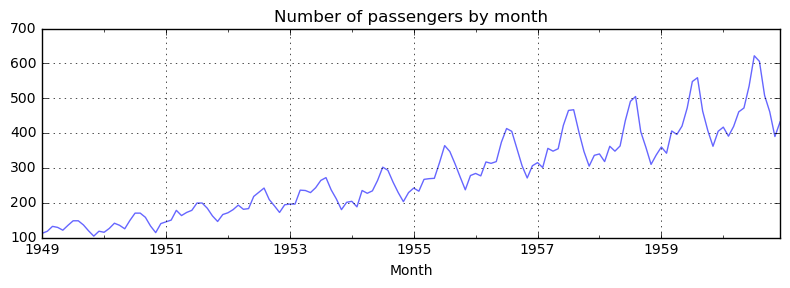

In [22]:
ax = ts.plot(figsize=(8, 3), alpha=0.6, legend=False, title="Number of passengers by month") # Note plotting direct from a Pandas Series
ax.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()

### Stationarity test

Visually we can see our dataset is not stationary. The mean is increasing over time. The variance also seems to be increasing over time. Covariance appears to be constant.

Lets plot the rolling mean and rolling variance (standard deviation, so in same unit as mean) to see this more clearly.

We'll also run the Dickey-Fuller test to determine analytically whether the data is stationary or not.

In [86]:
# Function to plot rolling means and run Dickey-Fuller stationarity test
def test_stationarity(ts):
    
    # Calculate rolling series
#     rolmn = pd.rolling_mean(ts, window=12) - old pandas
    rolmn = ts.rolling(12).mean() # rolling mean - pandas 0.23
#     rolstd = pd.rolling_std(ts, window=12) # rolling standard deviation - old pandas
    rolstd = ts.rolling(12).std() # rolling standard deviation - pandas 0.23
    
    # Plot rolling statistics
    fig, ax = plt.subplots(figsize=(8, 3))
    orig = ax.plot(ts, color="blue", label="Original", alpha=0.6)
    mean = ax.plot(rolmn, color="red", label="Rolling Mean", alpha=0.6)
    std = ax.plot(rolstd, color="black", label="Rolling Std", alpha=0.6)
    ax.legend(loc="best", fontsize=8)
    ax.set_title("Rolling Mean and Standard Deviation")
    ax.set_xlim(min(df.index))
    ax.grid()
    plt.tight_layout()
    plt.show() # Force chart to render before the test results
    
    # Dickey-Fuller stationarity test
    print("Results of Dickey-Fuller test:")
    dftest = adfuller(ts, autolag="AIC")
    df_output = pd.Series(dftest[0:4], index=["Test statistic", "p-value", "#Lags used", "Number of observations used"])
    for key, value in dftest[4].items():
        df_output["Critical value (%s)" % key] = value
    print(df_output)

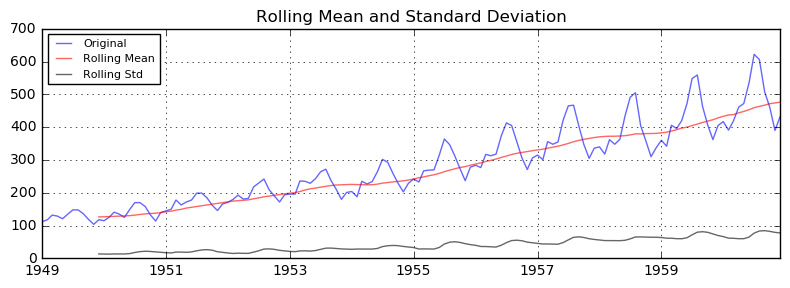

Results of Dickey-Fuller test:
Test statistic                   0.815369
p-value                          0.991880
#Lags used                      13.000000
Number of observations used    130.000000
Critical value (5%)             -2.884042
Critical value (1%)             -3.481682
Critical value (10%)            -2.578770
dtype: float64


In [87]:
test_stationarity(ts)

### Interpreting the Dickey-Fuller test results

- H0: TS is non-stationary.
- H1: TS is stationary.

If test statistic < critical value then reject H0. (Signed values should be compared, not absolute values).

We got a Test statistic of 0.815 which is significantly (see p-value) highter than the Critical values, so we cannot reject H0. Hence, our dataset is non-stationary.

We need to make the dataset stationary in order to construct a time series forecast. Although its practically impossible to make a dataset perfectly stationary we'll try to get it as close as possible.

### Modeling approach

- Make the dataset stationary by removing:
    - Trend (use differencing)
    - Variance (use log transform)
    
- Forecast using the stationary dataset.

- Convert the forecast back to original scale by adding back the trend and seasonality estimates.

### Trend - estimating and eliminating

A common starting point for eliminating trend is to apply a transformation.

In our data we can clearly observe an upward trend. There are several possible techniques that will penalize larger values more than small values, including:
- log transformation
- square root
- cube root
- etc.

Lets apply a log transformation to our data for simplicity's sake:

In [25]:
ts_log = np.log(ts)

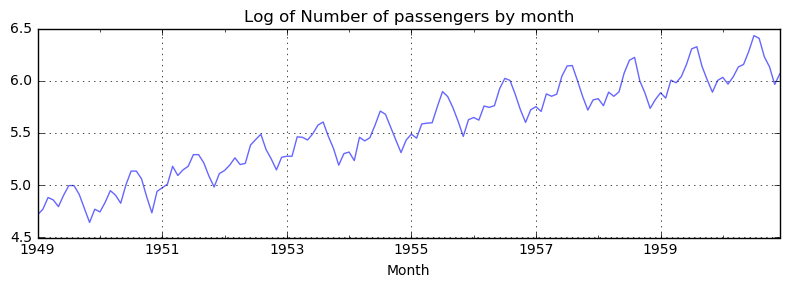

In [26]:
ax = ts_log.plot(figsize=(8, 3), alpha=0.6, legend=False, title="Log of Number of passengers by month") # Note plotting direct from a Pandas Series
ax.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()

Since our data is relatively simple and noise-free, it is straighforward to see the upward trend in the data. In other cases it may not be so easy.

What we need is a way of estimating (or modeling) this trend so that we can then remove it from the series.

There are various techniques for modeling the trend, including
- Aggregation (taking an average over a period of time, e.g. monthly or weekly wages)
- Smoothing (taking a rolling average)
- Polynomial fitting (fitting a regression model)

The best technique will vary by use case. Lets start here by trying smoothing.

Our dataset appears to contain seasonality, cycling approximately every 12 months. So we will use a window of 12 months to create a 1 year rolling average.

In [27]:
# Apply smoothing (simplenmoving average)
# moving_avg = pd.rolling_mean(ts_log, 12) # old pandas
moving_avg = ts_log.rolling(12).mean() # pandas 0.23

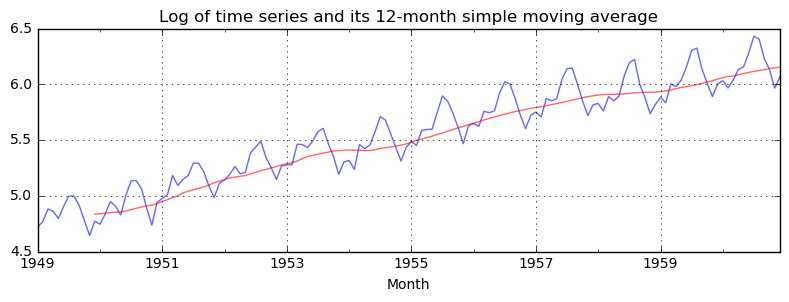

In [28]:
# Plot log of time series and its 12-month simple moving average
fig = plt.figure(figsize=(8, 3))
ax1 = ts_log.plot(alpha=0.6, color="blue")
ax2 = moving_avg.plot(alpha=0.6, color="red")
plt.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()
plt.title("Log of time series and its 12-month simple moving average")

Note that since we are creating a 12 month rolling mean, the first 11 points are missing:

In [29]:
moving_avg.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01    4.836178
Name: #Passengers, dtype: float64

Now we subtract the rolling average from the original log transform to remove the trend. We also need to drop the NA values. Then we'll plot the result to check the trend has been removed.

In [30]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

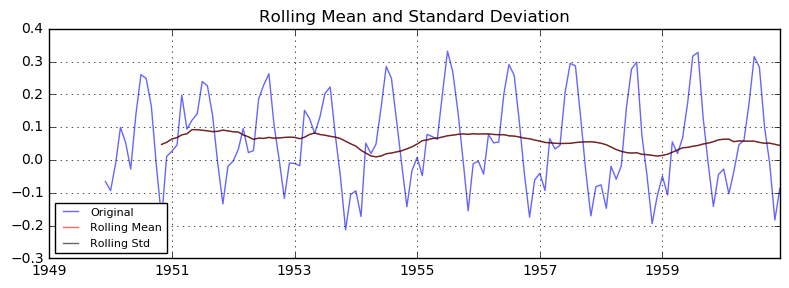

Results of Dickey-Fuller test:
Test statistic                  -3.162908
p-value                          0.022235
#Lags used                      13.000000
Number of observations used    119.000000
Critical value (5%)             -2.886151
Critical value (1%)             -3.486535
Critical value (10%)            -2.579896
dtype: float64


In [31]:
# Run Dickey-Fuller test on resulting series
test_stationarity(ts_log_moving_avg_diff)

This is a better series. Although there are some fluctuations in rolling mean and variation there is no clear trend. Further, the test statistic is below the Critical 5% value, so we can reject H0 and say with 95% confidence that this series is stationary.

A drawback to the simple moving average approach is that the time window has to be strictly defined. In this particular case its fine as we can take the 12 month average.

But in more complex cases (e.g. stock price prediction) the data may not be so friendly. In this case we can take a weighted moving average instead, where more recent periods are given higher weights. There are many techniques for assigning the weights, but the most popular is the **exponential moving average**, where weights are assigned to each previous value with decay factor. A further advantage of this technique over the simple moving average is that all values are assigned a weight, so we don't have the missing value problem we had above.

In [32]:
# Calculate Exponential Weighted Average (EWA)
# NB: half-life gives the number of periods it takes for the weighting to reduce to half of the weight for most recent period.
# expweighted_avg = pd.ewma(ts_log, halflife=12) # old pandas
expweighted_avg = ts_log.ewm(halflife=12).mean() # pandas 0.23

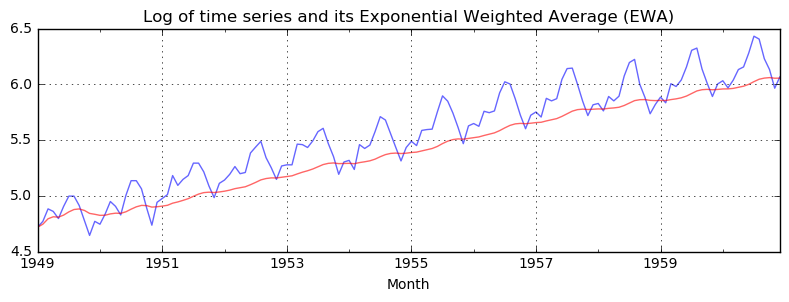

In [33]:
# Plot log of time series and its Exponential Weighted Average (EWA)
fig = plt.figure(figsize=(8, 3))
ax1 = ts_log.plot(alpha=0.6, color="blue")
ax2 = expweighted_avg.plot(alpha=0.6, color="red")
plt.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()
plt.title("Log of time series and its Exponential Weighted Average (EWA)")

Now, let's remove the EWA from the series and check for stationarity:

In [34]:
# Subtract EWA from series
ts_log_ewma_diff = ts_log - expweighted_avg

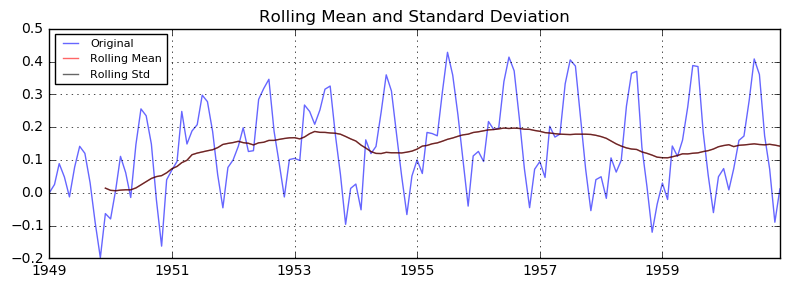

Results of Dickey-Fuller test:
Test statistic                  -3.601262
p-value                          0.005737
#Lags used                      13.000000
Number of observations used    130.000000
Critical value (5%)             -2.884042
Critical value (1%)             -3.481682
Critical value (10%)            -2.578770
dtype: float64


In [35]:
# Run Dickey-Fuller test on resultant series
test_stationarity(ts_log_ewma_diff)

The resultant rolling mean and rolling standard deviation have less variation using the EWA than with the simple moving average. Further, the Dickey-Fuller test statistic of -3.6 is below the 1% critical value of -3.48, therefore we can be >99% confident that this adjusted series is now stationary.

Also, as all values receive a weight when calcuating EWA, we don't have the missing value issue we encountered earlier. Note, however, that the initial values for EWA should be taken with caution, since at the start of the series the EWA has to be initialized from some value (either the current value or the simple weighted average of some window of past values), so this is initial EWA is an estimate.

### Eliminating trend and seasonality

The trend elimination techniques described above don't work in all scenarios, in particular those with high seasonality.

Let's explore 2 techniques for eliminating both trend and seasonality:

- **Differencing**
- **Decomposition**

#### Differencing

Simply take the difference between the current value and a previous value (with some lag). A first order difference can be easily calculated with Pandas as follows:

In [36]:
# Calculate difference of log number of passengers
# NB: The defaulf of the shift function is a lag of 1 period.
ts_log_diff = ts_log - ts_log.shift()

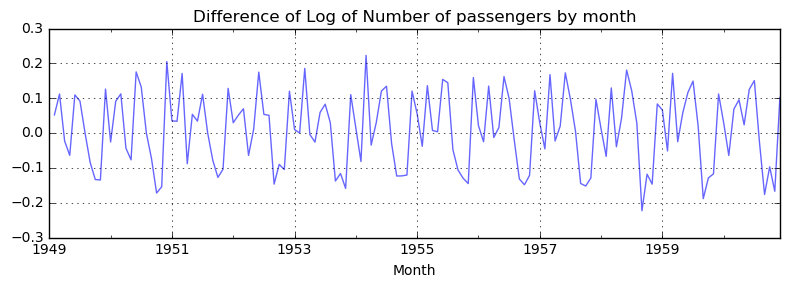

In [37]:
ax = ts_log_diff.plot(figsize=(8, 3), alpha=0.6, legend=False, title="Difference of Log of Number of passengers by month")
ax.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()

In [38]:
# NB: Because we are calculating the difference between a period and the previous period
# we get NaN for the first period in series. This needs to be dropped - see below.
ts_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

This appears to have reduced trend significantly. Lets verify that:

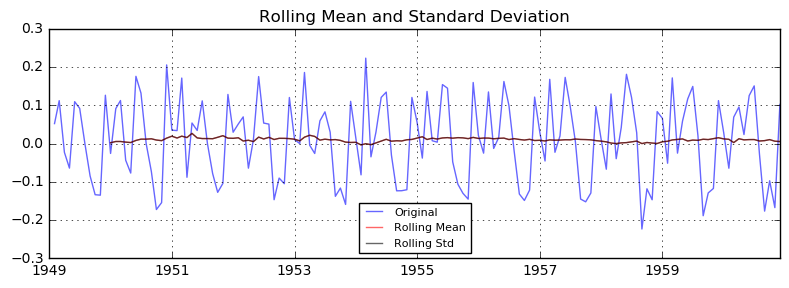

Results of Dickey-Fuller test:
Test statistic                  -2.717131
p-value                          0.071121
#Lags used                      14.000000
Number of observations used    128.000000
Critical value (5%)             -2.884398
Critical value (1%)             -3.482501
Critical value (10%)            -2.578960
dtype: float64


In [39]:
# Run Dickey-Fuller test on resultant series
ts_log_diff.dropna(inplace=True) # The first period is missing so needs to be dropped
test_stationarity(ts_log_diff)

We can see in the above plot that trend and changes in variange are very small over time. Also, the Dickey-Fuller test returns a test statistic of -2.72, which is less than the 10% critical value; so we can say that with the 90% confidence the series is stationary.

In certain scenarios, a second or even third order difference may be appropriate. Lets try that with our dataset:

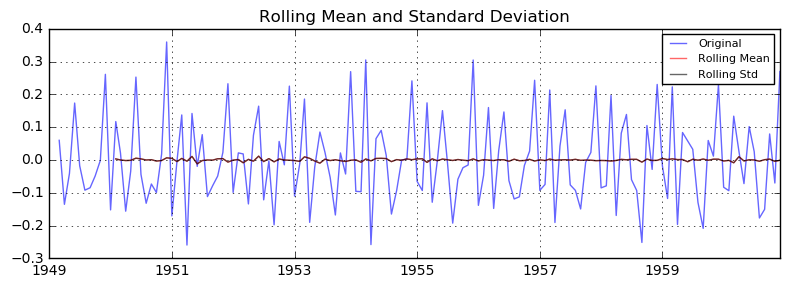

Results of Dickey-Fuller test:
Test statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags used                     1.300000e+01
Number of observations used    1.280000e+02
Critical value (5%)           -2.884398e+00
Critical value (1%)           -3.482501e+00
Critical value (10%)          -2.578960e+00
dtype: float64


In [40]:
# Try 2nd order differencing
ts_log_diff2 = ts_log_diff - ts_log_diff.shift()
ts_log_diff2.dropna(inplace=True)
test_stationarity(ts_log_diff2)

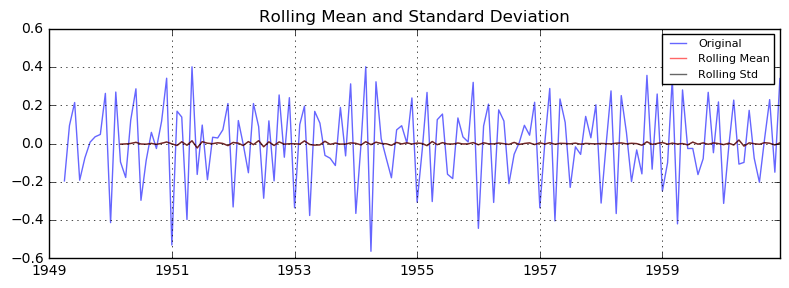

Results of Dickey-Fuller test:
Test statistic                -9.824011e+00
p-value                        5.246133e-17
#Lags used                     1.400000e+01
Number of observations used    1.260000e+02
Critical value (5%)           -2.884766e+00
Critical value (1%)           -3.483346e+00
Critical value (10%)          -2.579156e+00
dtype: float64


In [41]:
# Try 3rd order differencing
ts_log_diff3 = ts_log_diff2 - ts_log_diff2.shift()
ts_log_diff3.dropna(inplace=True)
test_stationarity(ts_log_diff3)

#### Decomposing

In this approach, trend and seasonality are modeled separately and the remaining part of series is returned.

In [42]:
decomposition = seasonal_decompose(ts_log)

In [43]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

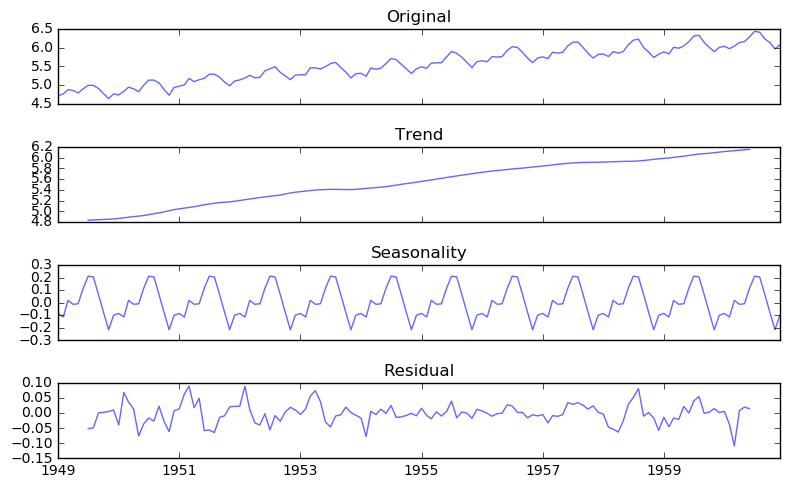

In [44]:
fig, axarr = plt.subplots(4, sharex=True, figsize=(8, 5))
axarr[0].plot(ts_log, alpha=0.6)
axarr[0].set_title("Original")
axarr[1].plot(trend, alpha=0.6)
axarr[1].set_title("Trend")
axarr[2].plot(seasonal, alpha=0.6)
axarr[2].set_title("Seasonality")
axarr[3].plot(residual, alpha=0.6)
axarr[3].set_title("Residual")
fig.tight_layout()

Now we've extracted the trend and seasonality from the original series, we can check the stationarity of the residuals:

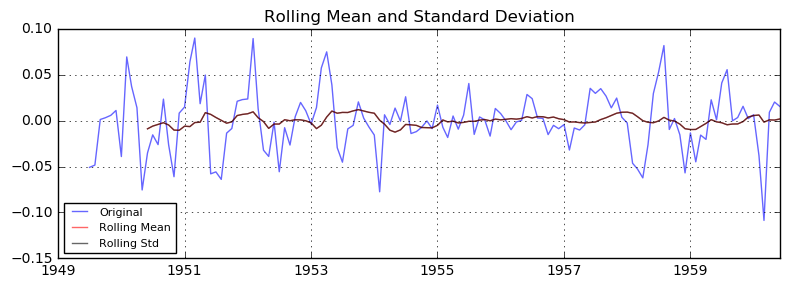

Results of Dickey-Fuller test:
Test statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags used                     9.000000e+00
Number of observations used    1.220000e+02
Critical value (5%)           -2.885538e+00
Critical value (1%)           -3.485122e+00
Critical value (10%)          -2.579569e+00
dtype: float64


In [45]:
residual.dropna(inplace=True)
test_stationarity(residual)

The Dickey-Fuller test shows that the residual series is very close to stationary as the test statistic of -6.33 is way below the critical 1% value of -3.49. So we can say that with greater than 99% confidence that the series is stationary.

There are more advance decomposition techniques, which can generate better results.

Converting the residuals back into the original values for future data is not very intuitive in this case.

### Forecasting a time series

#### About ARIMA

- Auto-Regressive (AR)
- Integrated (I)
- Moving-Average (MA)

ARIMA(p, d, q), where:
- p = AR
- d = I
- q = MA

The idea of ARIMA is to extract all the information out of the original data until we are just left with a residual (a.k.a. white noise), then we model the residual. Like extracting juice from sugar cane. We need to feed the sugar cane through the juice extractor multiple times to extract all the juice; this is how an ARIMA model works too.

Each of the 3 stages (AR, I and MA) are attempts to extract information (juice) from the series. After extracting all the juice we should be left with a sequence that displays a white-noise pattern, or no pattern at all.

The ARIMA process is executed in the following order:

**Stage 1**: *Integrated* - subtract time series with its lagged series to extract trends ("differencing").

E.g. subtract October sales from November sales to produce a trendless residual series.

The formulae for various orders of differencing are as follows:

- No differencing (d=0): $Y'_t = Y_t$
- 1st order differencing (d=1): $Y'_t = Y_t - Y_{t-1}$
- 2nd order differencing (d=2): $Y'_t = Y_t - Y_{t-1} - (Y_{t-1} - Y_{t-2}) = Y_t - 2 \times Y_{t-1} + Y_{t-2}$

First order differencing is represented as ARIMA(0, 1, 0). The residual values of most time series become **trendless** after first order differencing.

Below we apply first order differencing to our original time series data. Note that, despite the Dickey-Fuller test statistic being below the critical 10% level, the series is not yet stationary as variation is changing over time.

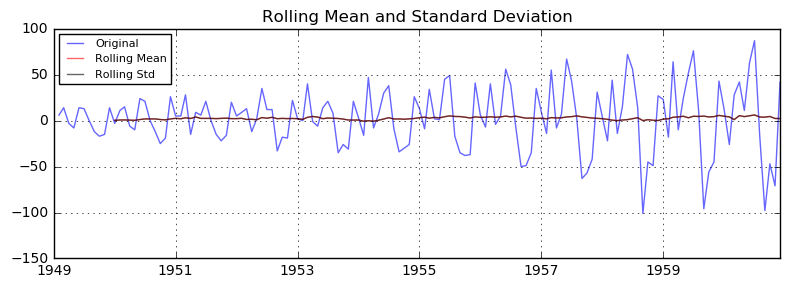

Results of Dickey-Fuller test:
Test statistic                  -2.829267
p-value                          0.054213
#Lags used                      12.000000
Number of observations used    130.000000
Critical value (5%)             -2.884042
Critical value (1%)             -3.481682
Critical value (10%)            -2.578770
dtype: float64


In [46]:
ts_1storderdiff = (ts-ts.shift()).dropna()
test_stationarity(ts_1storderdiff)

**Stage 2:** *Auto-Regressive* - extract the influence of the previous periods' values on the current period.

After running the "Integrated" part of the ARIMA model, the "Auto-Regressive" part gets activated. Here we extract the effect of the previous periods's values on the current period by building a regression model. The general form of the regression model is as follows:

$Y_t = c + \phi_1Y_{t-1} + \phi_2Y_{t-2}...+ \space \phi_pY_{t-p} + e_t$

An Auto-Regressive (AR) model of order 1, ARIMA(1, 0, 0), is:

$Y_t = c + \phi_1Y_{t-1} + e_t$

**Stage 3:** *Moving-Average* - extract the influence of the previous periods' error terms on the current period's error.

The 3rd and final stage of ARIMA is to find the relationship between the previous periods' error terms and the current periods error term. The error term for a period is the difference between the moving average and the actual value.

$Y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2}... + \space \theta_q e_{t-q}$

A Moving Average (MA) model of order 1, ARIMA(0, 0, 1), is:

$Y_t = c + e_t + \theta_1 e_{t-1}$

#### Distinguishing between white noise and signal

If you stare at white noise (like the chart below or a t.v. screen after the station closes) for long enough, you may start to notice patterns that don't exist. Differentiating between signal and noise can be difficult, so we need a mathematical/logical method to help us.

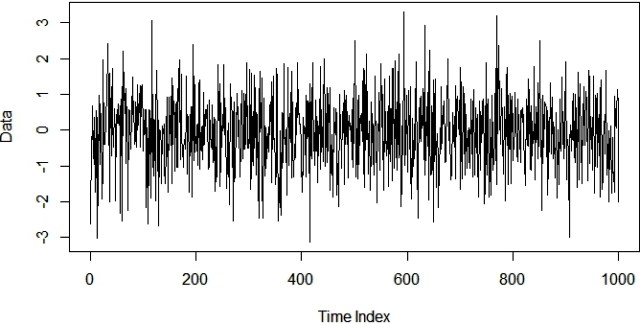

In [47]:
Image(filename="White-Nosie.jpeg")

#### Autocorrelation function (ACF)

ACF is a tool to help us distinguish between white noise and a true signal. ACF is developed by calculating the correlation between a time series and its lagged values. For a lag of 0, the correlation will obviously be a perfect 1, since we are comparing a time series period to itself. If a series has significant correlation with one of its lagged values, it may be a signal. If none of the correlations between a series and its different lagged values are significant, then we are probably analyzing a time series of pure white noise.

**This helps us idenify the q value for the ARIMA model.**

Let's remind ourselves how we got here. As a pre-step, we performed a log transform on the original series to reduce the scale of the trend and reduce variance. Then, we performed first order differencing to attempt to remove trend and seasonality altogether. That left us with the series ts_log_diff.

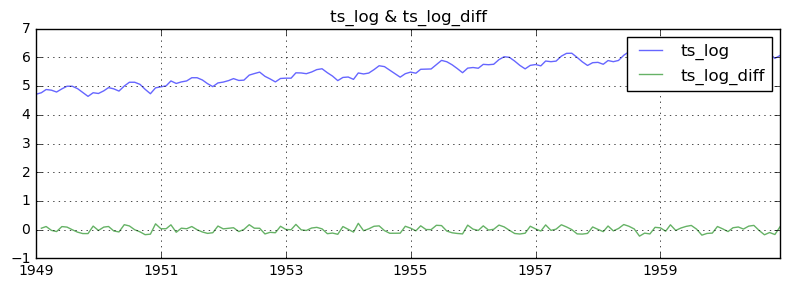

In [48]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ts_log, alpha=0.6)
ax.plot(ts_log_diff, alpha=0.6)
ax.set_title("ts_log & ts_log_diff")
ax.grid(True)
ax.legend(["ts_log","ts_log_diff"])
# ax.set_frame_on(False)
plt.tight_layout()

The question now is: is ts_log_diff pure white noise, or is there and remaining signal that needs to be removed? We'll attempt to answer that question using the ACF.

In [49]:
# lag_acf = acf(ts_log_diff, nlags=20)

# # 95% of values are within +/- 1.96 std devs
# # 99% of values are within +/- 2.58 std devs
# fig,ax = plt.subplots(figsize=(8, 3))
# ax.plot(lag_acf, alpha=0.6)
# ax.grid(True)
# ax.axhline(y=0, linestyle="-", color="gray")
# ax.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle="-", color="gray", label="95% significance")
# ax.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle="-", color="gray")
# ax.axhspan(-1.96/np.sqrt(len(ts_log_diff)), 1.96/np.sqrt(len(ts_log_diff)), alpha=0.03, color="blue")
# ax.axhline(y=-2.58/np.sqrt(len(ts_log_diff)), linestyle="--", color="gray", label="99% significance")
# ax.axhline(y=2.58/np.sqrt(len(ts_log_diff)), linestyle="--", color="gray")
# ax.set_xlabel("Lag")
# ax.set_ylabel("Autocorrelation")
# ax.set_title("Auto Correlation Function (ACF)")
# ax.legend(fontsize=8)

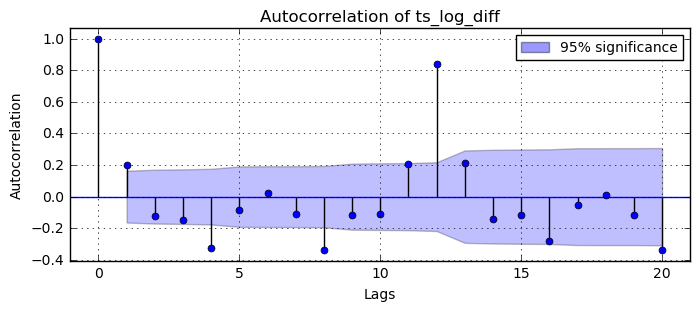

In [50]:
legend_elements = [Patch(facecolor="blue", alpha=0.4, label="95% significance")]

fig, ax = plt.subplots(figsize=(8, 3))
ax = tsaplots.plot_acf(ts_log_diff, lags=20, ax=ax, alpha=.05, title="Autocorrelation of ts_log_diff")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend(handles=legend_elements, fontsize=10)
plt.show()

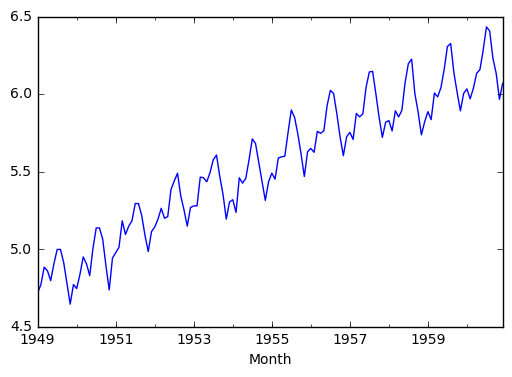

In [51]:
ts_log.plot()

In the ACF plot above, values outside the blue 95% significance band are indication of non-random autocorrelations, which means there is still signal (juice, to keep the sugar can analogy going) in the data to be extracted by the AR and MA models.

There is also clear evidence of seasonality left in the data at lag 12, which makes sense as we can observe the annual (12-month) seasonality in the original series. As a reminder, the seasonality component we extracted earlier is reproduced below.

**The first lag value that is outside the significance band can be used as the q value for the ARIMA model.**

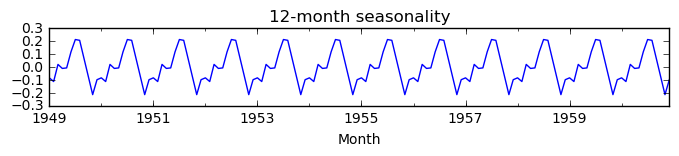

In [52]:
fig, ax = plt.subplots(figsize=(8, 1))
ax = seasonal.plot()
ax.set_title("12-month seasonality")

#### Partial Auto Correlation Function (PACF)

The PACF also helps us identify remaining non-stationarity in the series. It also is calculated as the correlation of a series with its lagged values, but this time, after removing the effects of intermediate periods. For example, for a lag value of 5, we calculate the correlation between t and t-5, but after eliminating the effect of periods t-1...t-4.

**This helps us identify the value for p in the ARIMA model.**

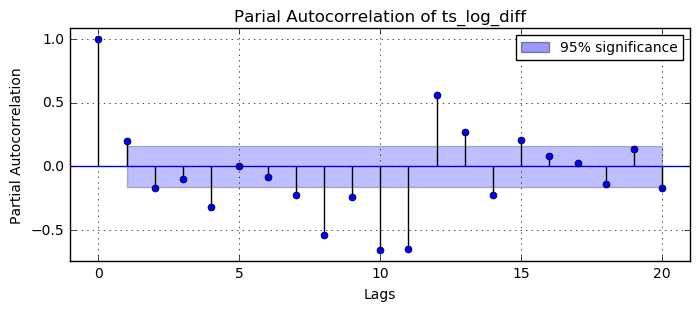

In [53]:
legend_elements = [Patch(facecolor="blue", alpha=0.4, label="95% significance")]

fig, ax = plt.subplots(figsize=(8, 3))
ax = tsaplots.plot_pacf(ts_log_diff, lags=20, ax=ax, alpha=.05, title="Parial Autocorrelation of ts_log_diff")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.grid(True)
plt.legend(handles=legend_elements, fontsize=10)
plt.show()

#### Implement the ARIMA forecast

OK, let's now put this all together and attempt to make a forecast model for the time series.

We'll create 3 separate models:
- AR model
- MA model
- Combined model

##### AR model

In [54]:
model = ARIMA(ts_log, order=(1, 1, 1)) # d=1 for 1st order differencing
results_AR = model.fit(disp=-1) # disp<0 suppresses verbose output
RSS_AR = sum((results_AR.fittedvalues-ts_log_diff)**2)

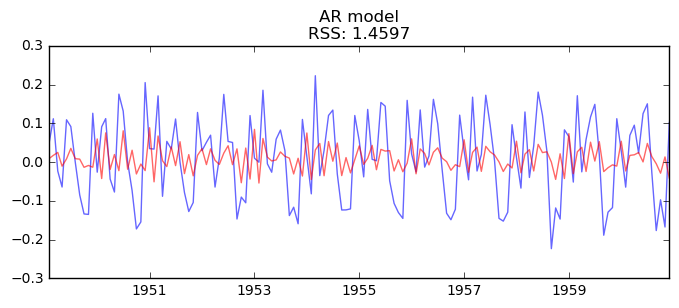

In [55]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ts_log_diff, alpha=0.6)
ax.plot(results_AR.fittedvalues, color="red", alpha=0.6)
ax.set_title("AR model\nRSS: %.4f" % RSS_AR)

##### MA model

In [56]:
model = ARIMA(ts_log, order=(10, 1, 2)) # d=1 for 1st order differencing
results_MA = model.fit(disp=-1) # disp<0 suppresses verbose output
RSS_MA = sum((results_MA.fittedvalues-ts_log_diff)**2)

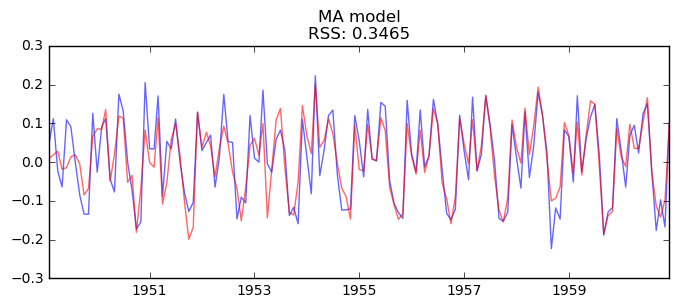

In [57]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ts_log_diff, alpha=0.6)
ax.plot(results_MA.fittedvalues, color="red", alpha=0.6)
ax.set_title("MA model\nRSS: %.4f" % RSS_MA)

##### Combined ARIMA model

In [58]:
p, d, q = 10, 1, 2 # d=1 for 1st order differencing
model = ARIMA(ts_log, order=(p, d, q)) 
results_ARIMA = model.fit(disp=-1) # disp<0 suppresses verbose output
RSS_ARIMA = sum((results_ARIMA.fittedvalues-ts_log_diff)**2)

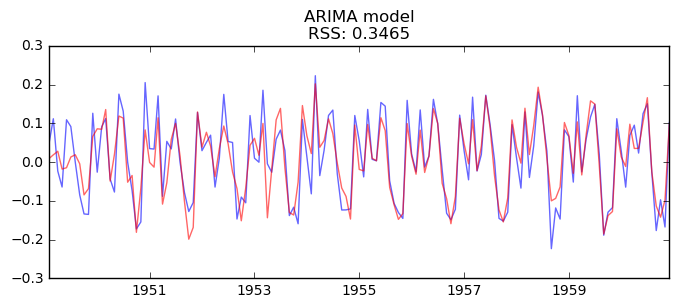

In [59]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ts_log_diff, alpha=0.6)
ax.plot(results_ARIMA.fittedvalues, color="red", alpha=0.6)
ax.set_title("ARIMA model\nRSS: %.4f" % RSS_ARIMA)

The combined ARIMA model performs better that the individual AR and MA models, so lets use the combined model going forward.

The next step is to convert the fit model back to the original scale.

##### Convert ARIMA model back to original scale

First, lets store the predicted values as a separate series and observe it:

In [60]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009958
1949-03-01    0.019008
1949-04-01    0.028196
1949-05-01   -0.017759
1949-06-01   -0.014247
dtype: float64

Notice that this new series doesn't start at the first month. That's because we did first order differencing, so there was no prior period for the first month to difference against.

Remember that these predictions are predictions for the series after we did differencing and the log transform. So, next let's convert them back to the log transformed series, by adding the cumulative sum of the differences back to the base value. Then, we'll take the exponent of the log transformed series, to convert them back to the original scale.

In [61]:
# First, calculate the cumulative sum of the differences series:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009958
1949-03-01    0.028966
1949-04-01    0.057163
1949-05-01    0.039403
1949-06-01    0.025157
dtype: float64

In [62]:
# Base value
ts_log.ix[0]

4.718498871295094

In [63]:
# Series where every value is the base. Later, we'll add the differences to this series.
predictions_ARIMA_log = pd.Series(ts_log.ix[0], ts_log.index)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [64]:
# Add the differences to the base value series above to get back to the log transform series
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728457
1949-03-01    4.747465
1949-04-01    4.775661
1949-05-01    4.757902
dtype: float64

In [65]:
# Now, we simply take the exponent of the log transformed series to get back to original scale!
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA.head()

Month
1949-01-01    112.000000
1949-02-01    113.120893
1949-03-01    115.291665
1949-04-01    118.588727
1949-05-01    116.501290
dtype: float64

In [66]:
# Create date index for the forecast values
forecast_index = pd.Series([ts.index[-1] + DateOffset(months=x) for x in range(1,25)])

In [67]:
# Create a 24 month forecast
forecast = results_ARIMA.forecast(steps=24)
forecast_vals = pd.Series(np.exp(results_ARIMA.forecast(steps=24)[0]), index=forecast_index)

In [68]:
# Get the lower and upper 95% confidence values for the forecast
forecast_CI = forecast[2]
forecast_CI_lower = pd.Series(np.exp([x[0] for x in forecast_CI]), index=forecast_index)
forecast_CI_upper = pd.Series(np.exp([x[1] for x in forecast_CI]), index=forecast_index)

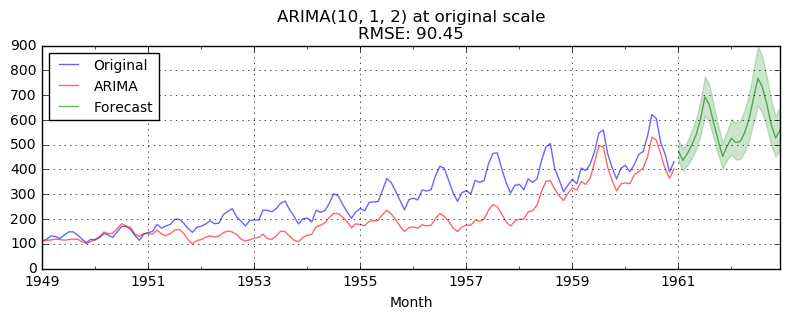

In [81]:
# Plot the fit model at the original scale vs the original series
RMSE_ARIMA = np.sqrt((sum((ts-predictions_ARIMA)**2))/len(ts))

fig = plt.figure(figsize=(8, 3))
ax1 = ts.plot(alpha=0.6, color="blue", label="Original")
ax2 = predictions_ARIMA.plot(alpha=0.6, color="red", label="ARIMA")
ax3 = forecast_vals.plot(alpha=0.6, color="green", label="Forecast")
# ax4 = forecast_CI_lower.plot(alpha=0.6, color="gray", label="95% confidence")
# ax5 = forecast_CI_upper.plot(alpha=0.6, color="gray", label="")
plt.fill_between(forecast_CI_lower.index, forecast_CI_lower, forecast_CI_upper, alpha=0.2, color="green")
plt.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()
plt.title("ARIMA(%d, %d, %d) at original scale\nRMSE: %.2f" % (p, d, q, RMSE_ARIMA))
plt.legend(loc="upper left", fontsize=10)

##### Check residuals for any further juice to extract

In [70]:
residuals = ts - predictions_ARIMA
residuals.head()

Month
1949-01-01    4.263256e-14
1949-02-01    4.879107e+00
1949-03-01    1.670833e+01
1949-04-01    1.041127e+01
1949-05-01    4.498710e+00
dtype: float64

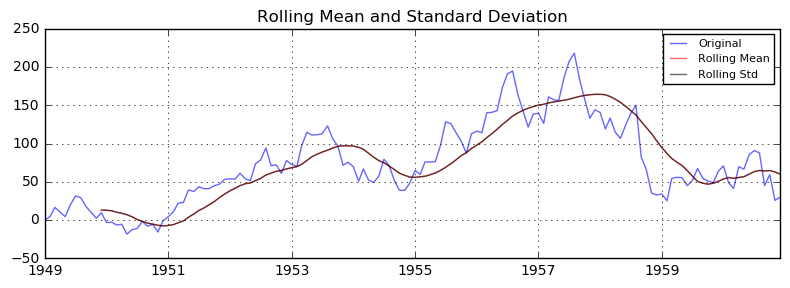

Results of Dickey-Fuller test:
Test statistic                  -2.227208
p-value                          0.196519
#Lags used                      14.000000
Number of observations used    129.000000
Critical value (5%)             -2.884219
Critical value (1%)             -3.482088
Critical value (10%)            -2.578864
dtype: float64


In [71]:
test_stationarity(residuals)

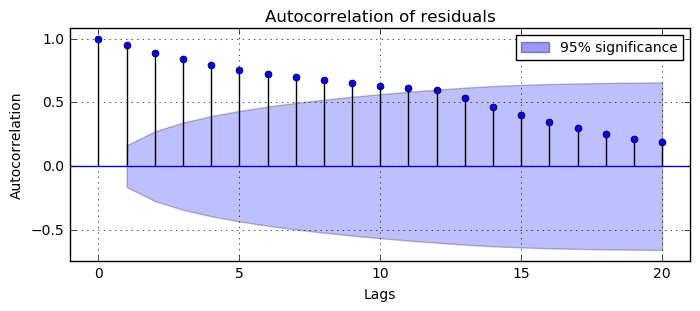

In [72]:
legend_elements = [Patch(facecolor="blue", alpha=0.4, label="95% significance")]

fig, ax = plt.subplots(figsize=(8, 3))
ax = tsaplots.plot_acf(residuals, lags=20, ax=ax, alpha=.05, title="Autocorrelation of residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend(handles=legend_elements, fontsize=10)
plt.show()

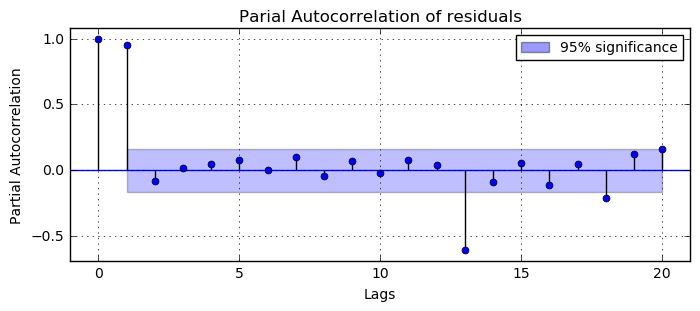

In [73]:
legend_elements = [Patch(facecolor="blue", alpha=0.4, label="95% significance")]

fig, ax = plt.subplots(figsize=(8, 3))
ax = tsaplots.plot_pacf(residuals, lags=20, ax=ax, alpha=.05, title="Parial Autocorrelation of residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.grid(True)
plt.legend(handles=legend_elements, fontsize=10)
plt.show()

##### Use auto_arima to find optimal parameters

In [74]:
stepwise_fit = auto_arima(ts, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1024.824, BIC=1039.200, Fit time=0.581 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1033.479, BIC=1039.229, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1022.316, BIC=1033.817, Fit time=0.402 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1022.904, BIC=1034.405, Fit time=0.443 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1022.343, BIC=1030.968, Fit time=0.133 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1021.142, BIC=1035.518, Fit time=1.466 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1016.962, BIC=1034.213, Fit time=5.467 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1033.378, BIC=1047.754, Fit time=3.596 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1018.093, BIC=1038.219, Fit time=7.262 seconds
Fit ARIMA: order=(1, 1, 1) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -502.481
Date:                            Fri, 27 Jul 2018   AIC                           1016.962
Time:                                    20:57:25   BIC                           1034.213
Sample:                                         0   HQIC                          1023.972
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.178      0.030      0.976      -0.344       0.355
ar.L1         -0.3771      0.077     -4.901      0.000      -0.528      -0.226
ar.S.L12       0.6886      0.140      4.902      0.000       0.413       0.964
ar.S.L24       0.3093      0.107      2.889      0.004       0.099       0.519
ma.S.L12      -0.9715      0.471     -2.064      0.039      -1.894      -0.049
sigma2       113.3323     44.381      2.554      0.011      26.348     200.317
===================================================================================
Ljung-Box (Q):                       58.63   Jarque-Bera (JB):                12.07
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
ts.index[0]

Timestamp('1949-01-01 00:00:00')

In [76]:
ts.index[-1]

Timestamp('1960-12-01 00:00:00')